In [1]:
# This use the EIA APIto get real time electricity prices for a given state
# Can be easily automated to run automatically as a sub process
# Can only get monthly! Need to find daily somewhere, however process will be the same
# https://api.electricitymap.org/ these guys provide live hourly data -> costs £500/month
# https://www.eia.gov/opendata/qb.php

In [9]:
import eia
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [10]:
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    api: API that we're connected to
    series_ID: string. Name of the series that we want to pull from the EIA API
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    df = pd.DataFrame(series_search)
    return df
    

In [11]:

#Create EIA API using your specific API key
api_key = "716c2a14953da546decd4f96c16aba8d"
api = eia.API(api_key)
    
#Pull the electricity price data
series_ID='ELEC.PRICE.TX-ALL.M'
electricity_df=retrieve_time_series(api, series_ID)
electricity_df.reset_index(level=0, inplace=True)
#Rename the columns for easer analysis
electricity_df.rename(columns={'index':'Date',
            electricity_df.columns[1]:'Electricity_Price'}, 
            inplace=True)

In [12]:
#Convert the Date column into a date object
electricity_df['Date']=pd.to_datetime(electricity_df['Date'])

In [13]:
#Set Date as a Pandas DatetimeIndex
electricity_df.index=pd.DatetimeIndex(electricity_df['Date'])

In [14]:
electricity_df.drop('Date', axis = 1, inplace = True)

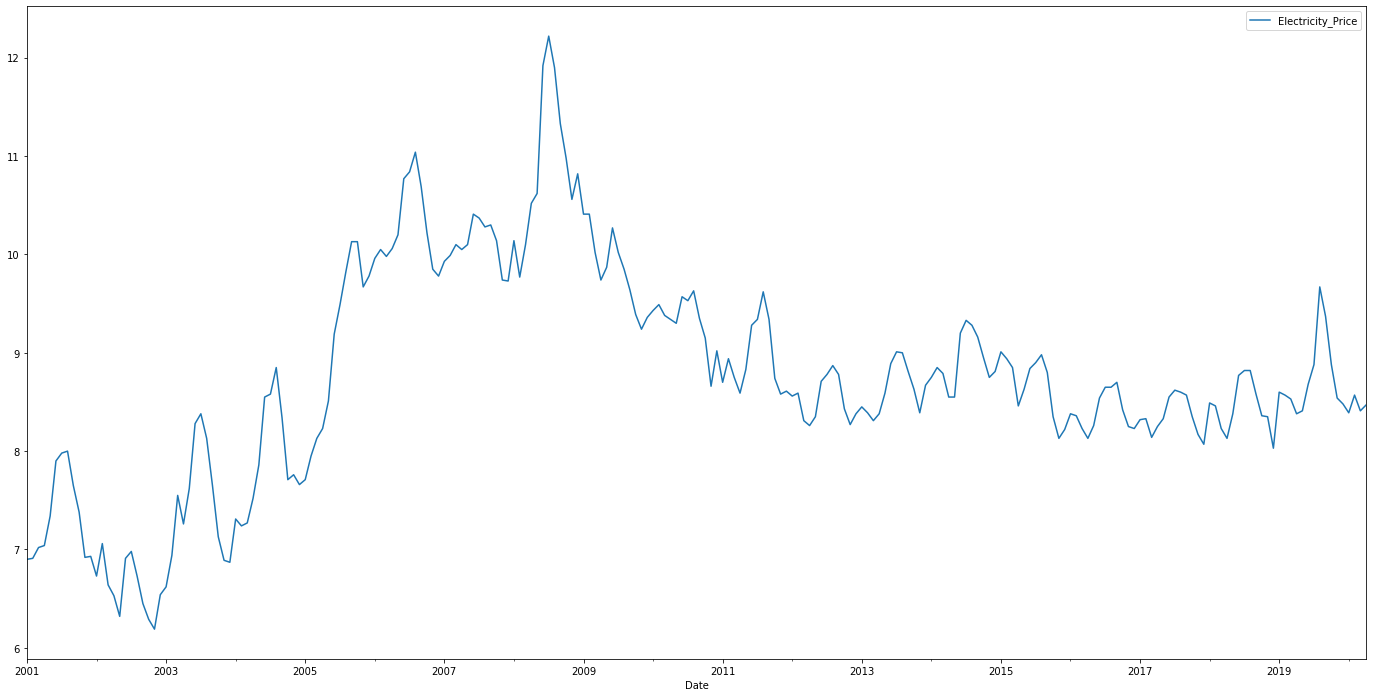

In [15]:
electricity_df.plot(figsize=(24,12))

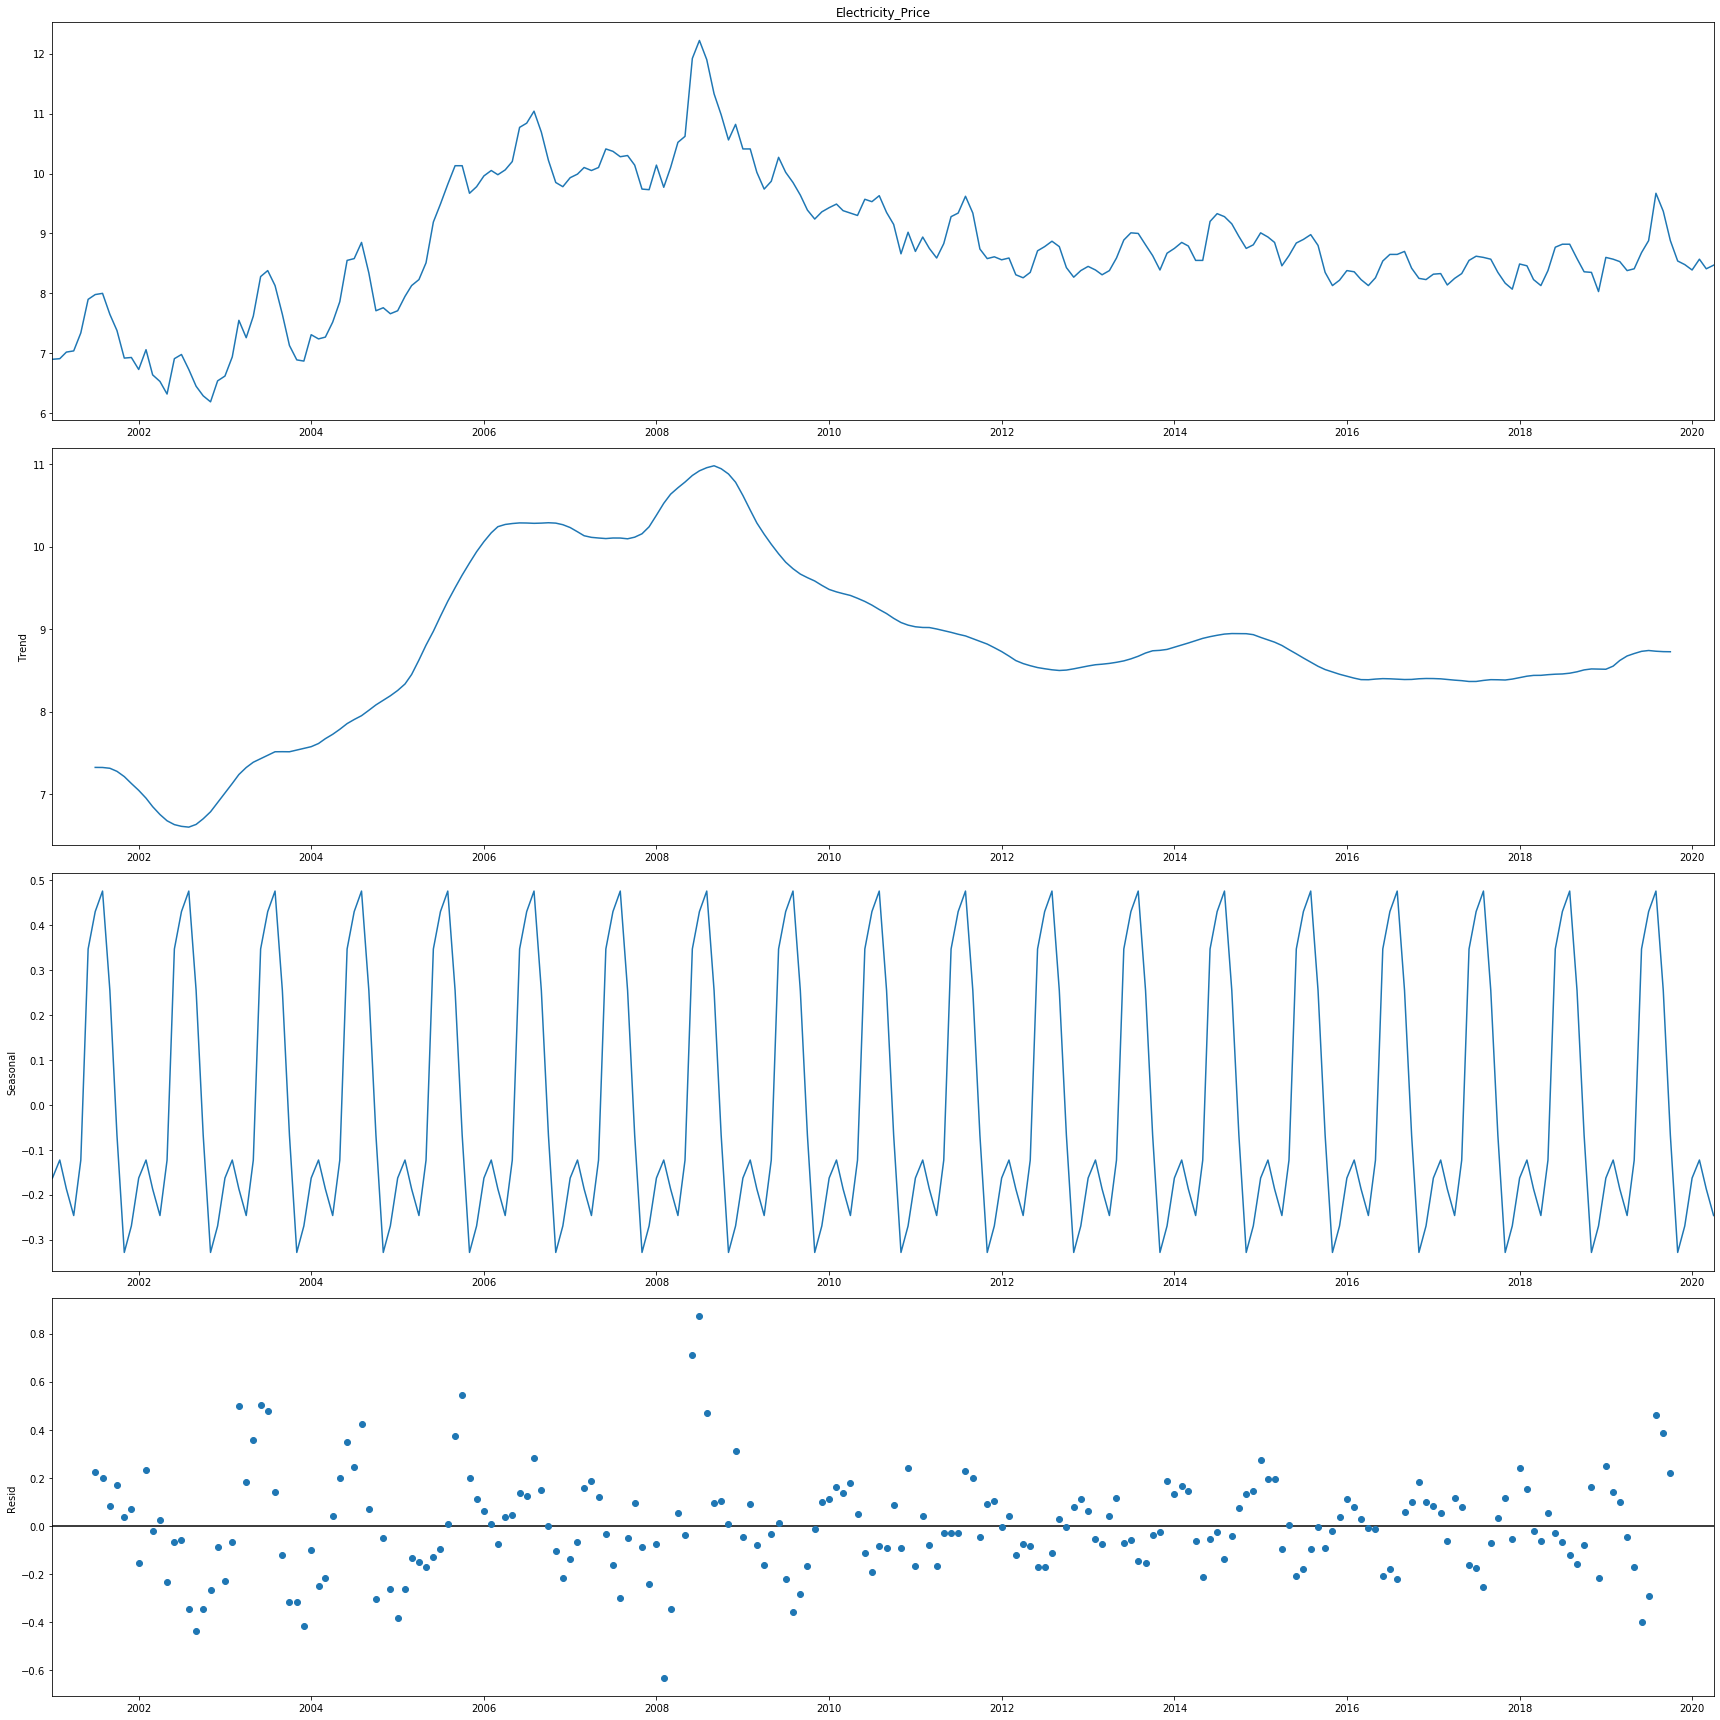

In [16]:
#Performing seasonal decomposition

from pylab import rcParams
rcParams['figure.figsize'] = 24,24
result = seasonal_decompose(electricity_df['Electricity_Price'], model='additive')
fig = result.plot()
plt.show()

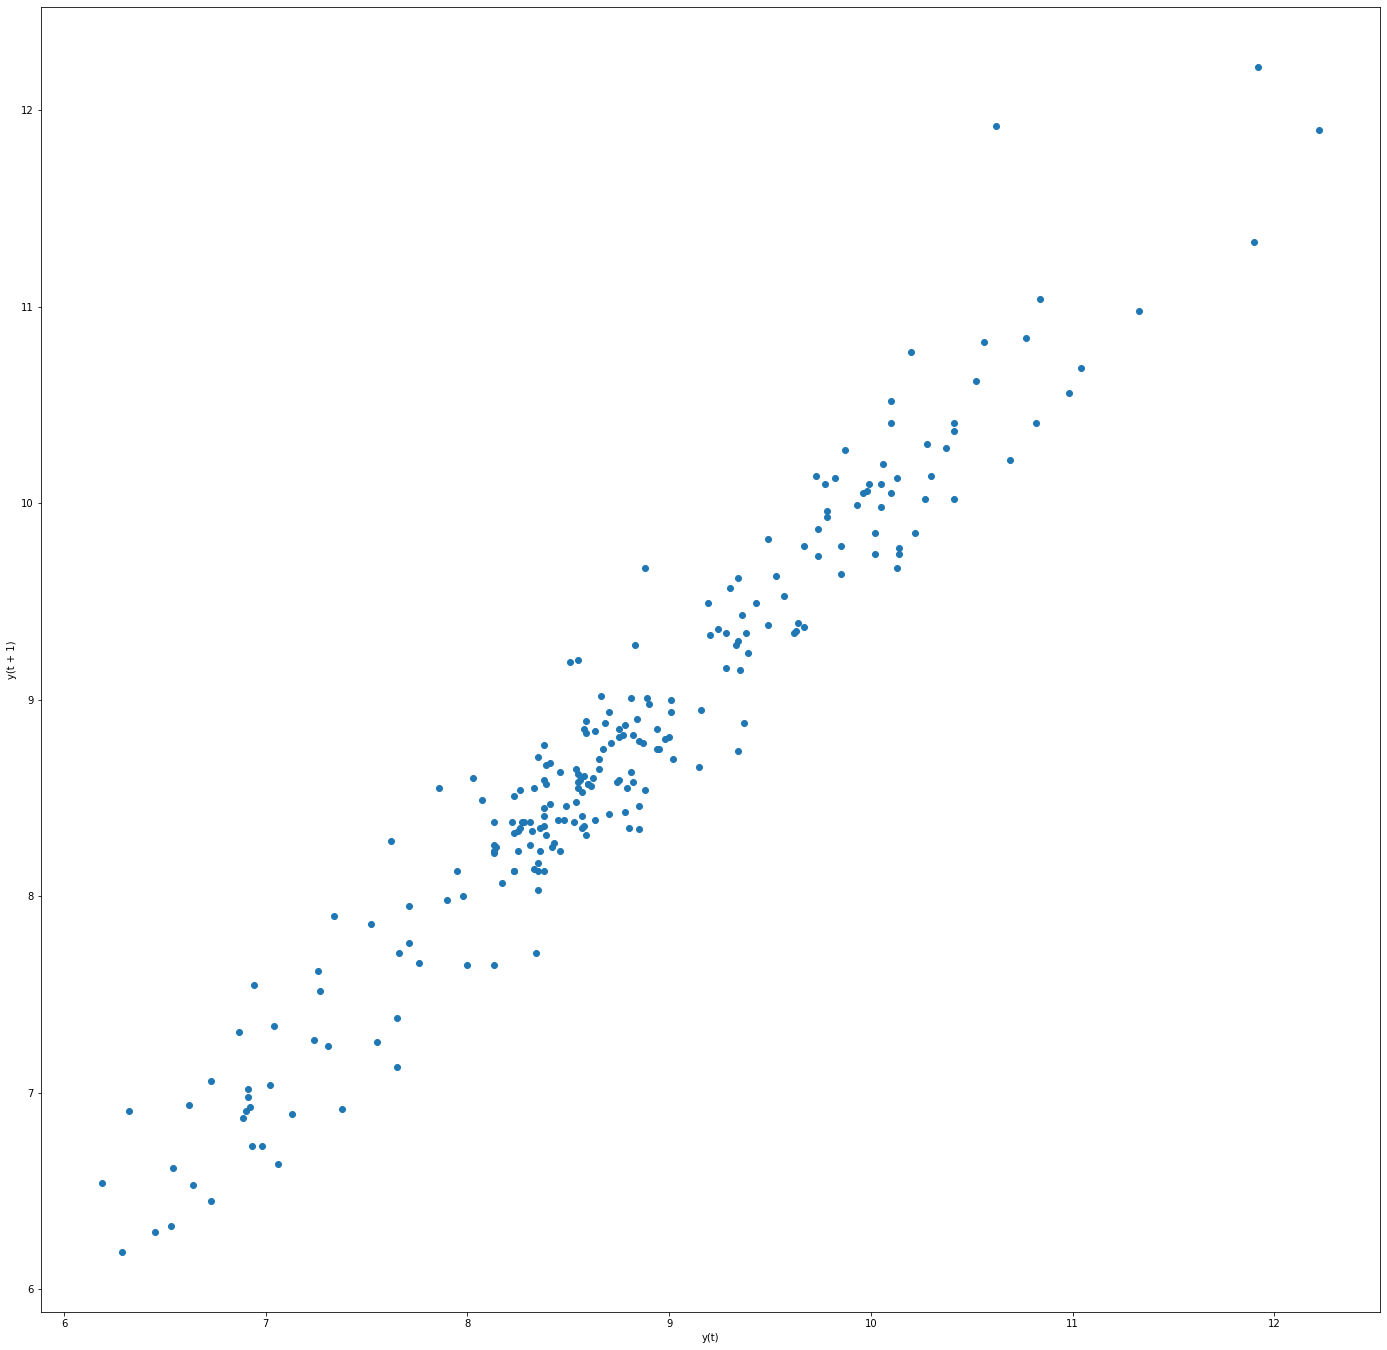

In [17]:
#Autocorrelation plot
from pandas.plotting import lag_plot

lag_plot(electricity_df['Electricity_Price']);

In [ ]:
# Good autocorrelation

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,0,1,12) [intercept=True]; AIC=-44.829, BIC=-17.290, Time=1.515 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=69.681, BIC=76.565, Time=0.088 seconds
Fit ARIMA(1,1,0)x(1,0,0,12) [intercept=True]; AIC=12.572, BIC=26.342, Time=0.278 seconds
Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=34.484, BIC=48.253, Time=0.275 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=67.818, BIC=71.260, Time=0.032 seconds
Fit ARIMA(2,1,2)x(0,0,1,12) [intercept=True]; AIC=4.498, BIC=28.595, Time=1.126 seconds
Near non-invertible roots for order (2, 1, 2)(0, 0, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA(2,1,2)x(1,0,0,12) [intercept=True]; AIC=-3.762, BIC=20.334, Time=1.448 seconds
Near non-invertible roots for order (2, 1, 2)(1, 0, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA(2,1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  232
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                  29.638
Date:                              Wed, 01 Jul 2020   AIC                            -47.277
Time:                                      15:58:44   BIC                            -26.622
Sample:                                           0   HQIC                           -38.946
                                              - 232                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.639e-05      0.001      0.122      0.903      -0.001       0.001
ma.L1          0.0050      0.060      0.083      0.934      -0.112       0.122
ma.L2          0.1140      0.051      2.232      0.026       0.014       0.214
ar.S.L12       0.9918      0.009    106.009      0.000       0.973       1.010
ma.S.L12      -0.8723      0.073    -12.022      0.000      -1.015      -0.730
sigma2         0.0418      0.003     12.530      0.000       0.035       0.048
===================================================================================
Ljung-Box (Q):                       24.87   Jarque-Bera (JB):                30.34
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.50
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [135]:
len(electricity_df)

232

In [136]:
# Set one year for testing
train = electricity_df.iloc[:219]
test = electricity_df.iloc[219:]

In [138]:
model = SARIMAX(train['Electricity_Price'],order=(0,1,2),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                    Electricity_Price   No. Observations:                  219
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                  32.102
Date:                              Wed, 01 Jul 2020   AIC                            -54.203
Time:                                      16:01:01   BIC                            -37.281
Sample:                                  01-01-2001   HQIC                           -47.368
                                       - 03-01-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0113      0.060     -0.189      0.850      -0.129       0.106
ma.L2          0.1479      0.052      2.866      0.004       0.047       0.249
ar.S.L12       0.9908      0.011     92.575      0.000       0.970       1.012
ma.S.L12      -0.8605      0.080    -10.704      0.000      -1.018      -0.703
sigma2         0.0401      0.004     10.273      0.000       0.032       0.048
===================================================================================
Ljung-Box (Q):                       34.01   Jarque-Bera (JB):                10.92
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [139]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,2)(1,0,1,12) Predictions')

In [140]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Electricity_Price'][i]}")

predicted=8.468029148, expected=8.38
predicted=8.599441155, expected=8.41
predicted=8.981380581, expected=8.68
predicted=9.046952703, expected=8.88
predicted=9.059684113, expected=9.67
predicted=8.905745079, expected=9.37
predicted=8.636765182, expected=8.88
predicted=8.450214998, expected=8.54
predicted=8.463795493, expected=8.48
predicted=8.632933074, expected=8.39
predicted=8.643631329, expected=8.57
predicted=8.550980922, expected=8.41
predicted=8.487587341, expected=8.47


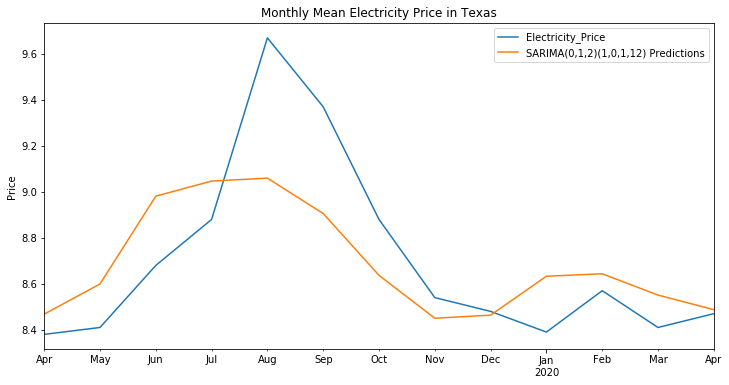

In [142]:
# Plot predictions against known values
title = 'Monthly Mean Electricity Price in Texas'
ylabel='Price'
xlabel=''

ax = test['Electricity_Price'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [143]:
# Evaluation

from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Electricity_Price'], predictions)
print(f'SARIMA(0,1,2)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) MSE Error: 0.06942067308


In [146]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Electricity_Price'], predictions)
print(f'SARIMA(0,1,2)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) RMSE Error: 0.2634780315


In [147]:
test['Electricity_Price'].mean()

8.702307692307691

In [148]:
# So looking at a significant error of $0.26 vs $8.70 dollars = 3% -> pretty decent!

In [161]:
# Retrainng on full data - Predicitions!
model = SARIMAX(electricity_df['Electricity_Price'],order=(0,0,2),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(electricity_df),len(electricity_df)+11,typ='levels').rename('SARIMA(0,1,2),(1,0,1,12) Forecast')

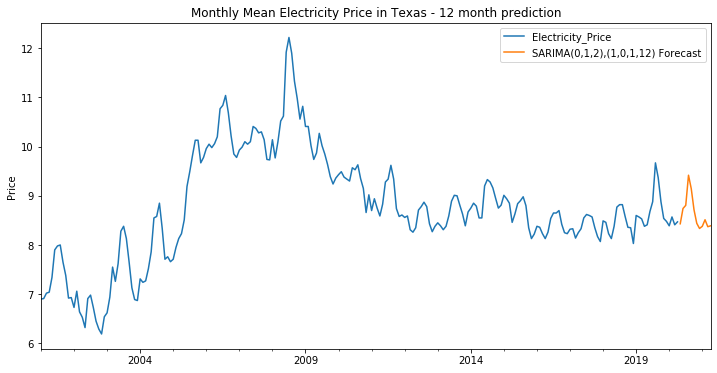

In [162]:
# Plot predictions (12 months) against known values
title = 'Monthly Mean Electricity Price in Texas - 12 month prediction'
ylabel='Price'
xlabel=''

ax = electricity_df['Electricity_Price'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [158]:
# Predict further into future!
# Retrainng on full data - Predicitions!
model = SARIMAX(electricity_df['Electricity_Price'],order=(0,0,2),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(electricity_df),len(electricity_df)+23,typ='levels').rename('SARIMA(0,1,2),(1,0,1,12) Forecast')

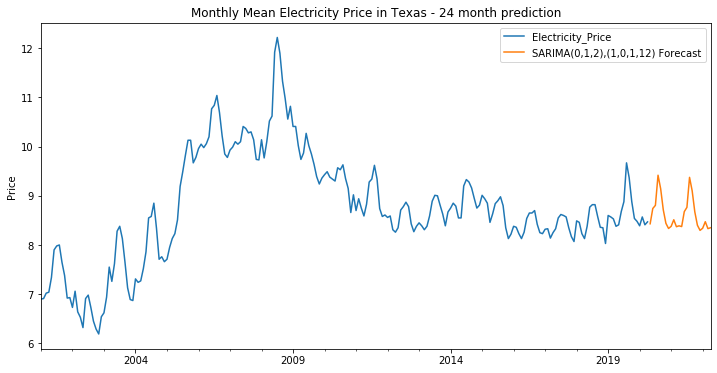

In [159]:
# Plot predictions (12 months) against known values
title = 'Monthly Mean Electricity Price in Texas - 24 month prediction'
ylabel='Price'
xlabel=''

ax = electricity_df['Electricity_Price'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);